# Genpact Hackathon Challenge
The solution code is divided into the following sections:

* Data understanding
* Preprocessing
* Remove Outliers
* Mean Encoding
* Lag features
* Feature selection
* Initial Model Building with XGBoost
    * Model Evaluation
    * Submission
* Stacking with XGBoost and KNN
    * Hyperparameter tuning
    * Model Evaluation
    * Model Stacking with RidgeRegression
    * Prediction on Final Test data
    * Prepare the Submission file

## Load Libraries

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_log_error

from xgboost import XGBRegressor

%matplotlib inline
RANDOM_STATE = 42

## Data Understanding

In [14]:
train = pd.read_csv('data/train.csv')
print(train.shape)
train.head()

(456548, 9)


,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders
0,1379560,1,55,1885,136.83,152.29,0,0,177
1,1466964,1,55,1993,136.83,135.83,0,0,270
2,1346989,1,55,2539,134.86,135.86,0,0,189
3,1338232,1,55,2139,339.50,437.53,0,0,54
4,1448490,1,55,2631,243.50,242.50,0,0,40


In [15]:
fullfill_center = pd.read_csv('data/fulfilment_center_info.csv')
print(fullfill_center.shape)
fullfill_center.head()

(77, 5)


,center_id,city_code,region_code,center_type,op_area
0,11,679,56,TYPE_A,3.7
1,13,590,56,TYPE_B,6.7
2,124,590,56,TYPE_C,4.0
3,66,648,34,TYPE_A,4.1
4,94,632,34,TYPE_C,3.6


In [16]:
meal_info = pd.read_csv('data/meal_info.csv')
print(meal_info.shape)
meal_info.head()

(51, 3)


,meal_id,category,cuisine
0,1885,Beverages,Thai
1,1993,Beverages,Thai
2,2539,Beverages,Thai
3,1248,Beverages,Indian
4,2631,Beverages,Indian


In [17]:
test = pd.read_csv('data/test_QoiMO9B.csv')
print(test.shape)
test.head()

(32573, 8)


,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured
0,1028232,146,55,1885,158.11,159.11,0,0
1,1127204,146,55,1993,160.11,159.11,0,0
2,1212707,146,55,2539,157.14,159.14,0,0
3,1082698,146,55,2631,162.02,162.02,0,0
4,1400926,146,55,1248,163.93,163.93,0,0


In [18]:
final_submit = pd.read_csv('data/sample_submission_hSlSoT6.csv')
print(final_submit.shape)
final_submit.head()

(32573, 2)


,id,num_orders
0,1028232,0
1,1127204,0
2,1212707,0
3,1082698,0
4,1400926,0


## Data Preparation

Check if all the center_id's in training set are present in master df fullfill_center

In [19]:
list(set(train['center_id']).difference(set(fullfill_center['center_id'])))

[]

Also Check if all the center_id's in test set are present in master df fullfill_center

In [20]:
list(set(test['center_id']).difference(set(fullfill_center['center_id'])))

[]

Also Check if all the center_id's in test set are present in training set

In [21]:
list(set(test['center_id']).difference(set(train['center_id'])))

[]

Similarly check if meal_id's in training set are present in master df meal_info

In [22]:
list(set(train['meal_id']).difference(set(meal_info['meal_id'])))

[]

Now check if meal_id's in test set are present in master df meal_info

In [23]:
list(set(test['meal_id']).difference(set(meal_info['meal_id'])))

[]

Now check if meal_id's in test set are present in train set

In [24]:
list(set(test['meal_id']).difference(set(train['meal_id'])))

[]

### Combine the train and test dataset

In [25]:
master_df = train.append(test, sort=False)
print(master_df.shape)
master_df.head()

(489121, 9)


,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders
0,1379560,1,55,1885,136.83,152.29,0,0,177.0
1,1466964,1,55,1993,136.83,135.83,0,0,270.0
2,1346989,1,55,2539,134.86,135.86,0,0,189.0
3,1338232,1,55,2139,339.50,437.53,0,0,54.0
4,1448490,1,55,2631,243.50,242.50,0,0,40.0


### Merge fullfill center dataset with the master df

In [26]:
master_df = pd.merge(master_df, fullfill_center, how='inner', on='center_id')
master_df.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,city_code,region_code,center_type,op_area
0,1379560,1,55,1885,136.83,152.29,0,0,177.0,647,56,TYPE_C,2.0
1,1466964,1,55,1993,136.83,135.83,0,0,270.0,647,56,TYPE_C,2.0
2,1346989,1,55,2539,134.86,135.86,0,0,189.0,647,56,TYPE_C,2.0
3,1338232,1,55,2139,339.50,437.53,0,0,54.0,647,56,TYPE_C,2.0
4,1448490,1,55,2631,243.50,242.50,0,0,40.0,647,56,TYPE_C,2.0


### Merge Meal info dataset with the master df

In [27]:
master_df = pd.merge(master_df, meal_info, how='inner', on='meal_id')
master_df.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,city_code,region_code,center_type,op_area,category,cuisine
0,1379560,1,55,1885,136.83,152.29,0,0,177.0,647,56,TYPE_C,2.0,Beverages,Thai
1,1018704,2,55,1885,135.83,152.29,0,0,323.0,647,56,TYPE_C,2.0,Beverages,Thai
2,1196273,3,55,1885,132.92,133.92,0,0,96.0,647,56,TYPE_C,2.0,Beverages,Thai
3,1116527,4,55,1885,135.86,134.86,0,0,163.0,647,56,TYPE_C,2.0,Beverages,Thai
4,1343872,5,55,1885,146.50,147.50,0,0,215.0,647,56,TYPE_C,2.0,Beverages,Thai


### Rearrange the columns in order

In [28]:
master_df = master_df.reindex(columns=['id','week','center_id','meal_id','checkout_price','base_price','emailer_for_promotion','homepage_featured','city_code','region_code','center_type','op_area','category','cuisine','num_orders'])
master_df.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,city_code,region_code,center_type,op_area,category,cuisine,num_orders
0,1379560,1,55,1885,136.83,152.29,0,0,647,56,TYPE_C,2.0,Beverages,Thai,177.0
1,1018704,2,55,1885,135.83,152.29,0,0,647,56,TYPE_C,2.0,Beverages,Thai,323.0
2,1196273,3,55,1885,132.92,133.92,0,0,647,56,TYPE_C,2.0,Beverages,Thai,96.0
3,1116527,4,55,1885,135.86,134.86,0,0,647,56,TYPE_C,2.0,Beverages,Thai,163.0
4,1343872,5,55,1885,146.50,147.50,0,0,647,56,TYPE_C,2.0,Beverages,Thai,215.0


### Check for the missing values and the column types

In [29]:
master_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 489121 entries, 0 to 489120
Data columns (total 15 columns):
id                       489121 non-null int64
week                     489121 non-null int64
center_id                489121 non-null int64
meal_id                  489121 non-null int64
checkout_price           489121 non-null float64
base_price               489121 non-null float64
emailer_for_promotion    489121 non-null int64
homepage_featured        489121 non-null int64
city_code                489121 non-null int64
region_code              489121 non-null int64
center_type              489121 non-null object
op_area                  489121 non-null float64
category                 489121 non-null object
cuisine                  489121 non-null object
num_orders               456548 non-null float64
dtypes: float64(4), int64(8), object(3)
memory usage: 59.7+ MB


### Check for the unique values in each column

In [30]:
# Get the unique count
uni_count = []
for col in master_df.columns:
    uni_count.append(len(master_df[col].unique()))
    
pd.DataFrame({'Column':master_df.columns, 'Unique Count':uni_count})

,Column,Unique Count
0,id,489121
1,week,155
2,center_id,77
3,meal_id,51
4,checkout_price,1995
5,base_price,1931
6,emailer_for_promotion,2
7,homepage_featured,2
8,city_code,51
9,region_code,8


### Label Encode the categorical columns

In [31]:
lbl_enc = LabelEncoder()
master_df['center_type'] = lbl_enc.fit_transform(master_df['center_type'])
master_df['category'] = lbl_enc.fit_transform(master_df['category'])
master_df['cuisine'] = lbl_enc.fit_transform(master_df['cuisine'])

### View the value distributions of each column

In [32]:
master_df.describe()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,city_code,region_code,center_type,op_area,category,cuisine,num_orders
count,4.891210e+05,489121.000000,489121.000000,489121.000000,489121.000000,489121.000000,489121.000000,489121.000000,489121.000000,489121.000000,489121.000000,489121.000000,489121.000000,489121.000000,456548.000000
mean,1.249988e+06,79.810613,82.092206,2024.852268,332.879277,354.312259,0.080172,0.107346,601.551172,56.621065,0.642226,4.083865,5.255824,1.561199,261.872760
std,1.443421e+05,44.343325,45.973390,547.408978,153.022073,160.352168,0.271560,0.309552,66.182598,17.641296,0.815883,1.092163,4.455434,1.102316,395.922798
min,1.000000e+06,1.000000,10.000000,1062.000000,2.970000,55.350000,0.000000,0.000000,456.000000,23.000000,0.000000,0.900000,0.000000,0.000000,13.000000
25%,1.124937e+06,42.000000,43.000000,1558.000000,228.010000,243.500000,0.000000,0.000000,553.000000,34.000000,0.000000,3.600000,0.000000,1.000000,54.000000
50%,1.249977e+06,81.000000,76.000000,1993.000000,299.760000,311.430000,0.000000,0.000000,596.000000,56.000000,0.000000,4.000000,5.000000,2.000000,136.000000
75%,1.374988e+06,118.000000,110.000000,2539.000000,445.230000,458.810000,0.000000,0.000000,651.000000,77.000000,1.000000,4.500000,9.000000,3.000000,324.000000
max,1.499999e+06,155.000000,186.000000,2956.000000,1113.620000,1112.620000,1.000000,1.000000,713.000000,93.000000,2.000000,7.000000,13.000000,3.000000,24299.000000


## Split again into Train and test

In [33]:
train = master_df.loc[(master_df['week'] < 146)]
test = master_df.loc[(master_df['week'] >= 146)]
print(train.shape)
print(test.shape)

(456548, 15)
(32573, 15)


## Remove Outliers

In [34]:
np.percentile(train['num_orders'], [99.7,99.8,99.9,100])

array([ 2823.   ,  3278.872,  4137.889, 24299.   ])

In [35]:
train = train.loc[ train['num_orders'] < 5000 ]

In [36]:
np.percentile(train['checkout_price'], [99.7,99.8,99.9,100])

array([728.53, 728.53, 765.33, 866.27])

## Mean Encoding

In [37]:
for type_ids in [ ['center_id'], ['meal_id'], ['emailer_for_promotion'], ['homepage_featured'], ['city_code'], ['region_code'], ['center_type'], ['op_area'], ['category'], ['cuisine'], ['center_id', 'meal_id'], ['city_code', 'region_code'], ['category', 'cuisine'], ['center_type', 'op_area'], ['emailer_for_promotion', 'homepage_featured']]:
    for column_id in ['checkout_price', 'base_price', 'num_orders']:
        mean_df = train[type_ids + [column_id]].groupby(type_ids).agg(np.mean).reset_index()
        mean_df.rename(
            {column_id: "mean_of_"+column_id+"_groupby_"+"_".join(type_ids)},
            axis='columns', inplace=True
        )
        
        train = pd.merge(train, mean_df, on=type_ids, how='left')
        test = pd.merge(test, mean_df, on=type_ids, how='left')

In [38]:
print(train.shape)
train.head()

(456285, 60)


,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,city_code,region_code,...,mean_of_num_orders_groupby_city_code_region_code,mean_of_checkout_price_groupby_category_cuisine,mean_of_base_price_groupby_category_cuisine,mean_of_num_orders_groupby_category_cuisine,mean_of_checkout_price_groupby_center_type_op_area,mean_of_base_price_groupby_center_type_op_area,mean_of_num_orders_groupby_center_type_op_area,mean_of_checkout_price_groupby_emailer_for_promotion_homepage_featured,mean_of_base_price_groupby_emailer_for_promotion_homepage_featured,mean_of_num_orders_groupby_emailer_for_promotion_homepage_featured
0,1379560,1,55,1885,136.83,152.29,0,0,647,56,...,268.112879,126.409245,129.895395,555.991147,327.275187,349.970316,159.95595,335.811616,347.499698,211.311867
1,1018704,2,55,1885,135.83,152.29,0,0,647,56,...,268.112879,126.409245,129.895395,555.991147,327.275187,349.970316,159.95595,335.811616,347.499698,211.311867
2,1196273,3,55,1885,132.92,133.92,0,0,647,56,...,268.112879,126.409245,129.895395,555.991147,327.275187,349.970316,159.95595,335.811616,347.499698,211.311867
3,1116527,4,55,1885,135.86,134.86,0,0,647,56,...,268.112879,126.409245,129.895395,555.991147,327.275187,349.970316,159.95595,335.811616,347.499698,211.311867
4,1343872,5,55,1885,146.50,147.50,0,0,647,56,...,268.112879,126.409245,129.895395,555.991147,327.275187,349.970316,159.95595,335.811616,347.499698,211.311867


In [39]:
print(test.shape)
test.head()

(32573, 60)


,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,city_code,region_code,...,mean_of_num_orders_groupby_city_code_region_code,mean_of_checkout_price_groupby_category_cuisine,mean_of_base_price_groupby_category_cuisine,mean_of_num_orders_groupby_category_cuisine,mean_of_checkout_price_groupby_center_type_op_area,mean_of_base_price_groupby_center_type_op_area,mean_of_num_orders_groupby_center_type_op_area,mean_of_checkout_price_groupby_emailer_for_promotion_homepage_featured,mean_of_base_price_groupby_emailer_for_promotion_homepage_featured,mean_of_num_orders_groupby_emailer_for_promotion_homepage_featured
0,1028232,146,55,1885,158.11,159.11,0,0,647,56,...,268.112879,126.409245,129.895395,555.991147,327.275187,349.970316,159.95595,335.811616,347.499698,211.311867
1,1262649,147,55,1885,159.11,159.11,0,0,647,56,...,268.112879,126.409245,129.895395,555.991147,327.275187,349.970316,159.95595,335.811616,347.499698,211.311867
2,1453211,149,55,1885,157.14,158.14,0,0,647,56,...,268.112879,126.409245,129.895395,555.991147,327.275187,349.970316,159.95595,335.811616,347.499698,211.311867
3,1262599,150,55,1885,159.14,157.14,0,0,647,56,...,268.112879,126.409245,129.895395,555.991147,327.275187,349.970316,159.95595,335.811616,347.499698,211.311867
4,1495848,151,55,1885,160.11,159.11,0,0,647,56,...,268.112879,126.409245,129.895395,555.991147,327.275187,349.970316,159.95595,335.811616,347.499698,211.311867


## Create Lag features

In [40]:
cols = [
            'checkout_price',
            'base_price',
            'num_orders',
            'mean_of_checkout_price_groupby_center_id',
            'mean_of_base_price_groupby_center_id',
            'mean_of_num_orders_groupby_center_id',
            'mean_of_checkout_price_groupby_meal_id',
            'mean_of_base_price_groupby_meal_id',
            'mean_of_num_orders_groupby_meal_id',
            'mean_of_checkout_price_groupby_emailer_for_promotion',
            'mean_of_base_price_groupby_emailer_for_promotion',
            'mean_of_num_orders_groupby_emailer_for_promotion',
            'mean_of_checkout_price_groupby_homepage_featured',
            'mean_of_base_price_groupby_homepage_featured',
            'mean_of_num_orders_groupby_homepage_featured',
            'mean_of_checkout_price_groupby_city_code',
            'mean_of_base_price_groupby_city_code',
            'mean_of_num_orders_groupby_city_code',
            'mean_of_checkout_price_groupby_region_code',
            'mean_of_base_price_groupby_region_code',
            'mean_of_num_orders_groupby_region_code',
            'mean_of_checkout_price_groupby_center_type',
            'mean_of_base_price_groupby_center_type',
            'mean_of_num_orders_groupby_center_type',
            'mean_of_checkout_price_groupby_op_area',
            'mean_of_base_price_groupby_op_area',
            'mean_of_num_orders_groupby_op_area',
            'mean_of_checkout_price_groupby_category',
            'mean_of_base_price_groupby_category',
            'mean_of_num_orders_groupby_category',
            'mean_of_checkout_price_groupby_cuisine',
            'mean_of_base_price_groupby_cuisine',
            'mean_of_num_orders_groupby_cuisine',
            'mean_of_checkout_price_groupby_center_id_meal_id',
            'mean_of_base_price_groupby_center_id_meal_id',
            'mean_of_num_orders_groupby_center_id_meal_id',
            'mean_of_checkout_price_groupby_city_code_region_code',
            'mean_of_base_price_groupby_city_code_region_code',
            'mean_of_num_orders_groupby_city_code_region_code',
            'mean_of_checkout_price_groupby_category_cuisine',
            'mean_of_base_price_groupby_category_cuisine',
            'mean_of_num_orders_groupby_category_cuisine',
            'mean_of_checkout_price_groupby_center_type_op_area',
            'mean_of_base_price_groupby_center_type_op_area',
            'mean_of_num_orders_groupby_center_type_op_area',
            'mean_of_checkout_price_groupby_emailer_for_promotion_homepage_featured',
            'mean_of_base_price_groupby_emailer_for_promotion_homepage_featured',
            'mean_of_num_orders_groupby_emailer_for_promotion_homepage_featured'
        ]

# 1 Week Lag
# Train
df = train.copy()
df['week'] = df['week'] + 1
df = df[ ['week', 'center_id', 'meal_id'] + cols ]
df.rename({ col: col + '_1_week_ago' for col in cols }, axis=1, inplace=True)
train = pd.merge(train, df, on=['week', 'center_id', 'meal_id'], how='left')

# Test
df = test.copy()
df['week'] = df['week'] + 1
df = df[ ['week', 'center_id', 'meal_id'] + cols ]
df.rename({ col: col + '_1_week_ago' for col in cols }, axis=1, inplace=True)
test = pd.merge(test, df, on=['week', 'center_id', 'meal_id'], how='left')


# 2 Weeks Lag
# Train
df = train.copy()
df['week'] = df['week'] + 2
df = df[ ['week', 'center_id', 'meal_id'] + cols ]
df.rename({ col: col + '_2_weeks_ago' for col in cols }, axis=1, inplace=True)
train = pd.merge(train, df, on=['week', 'center_id', 'meal_id'], how='left')

# Test
df = test.copy()
df['week'] = df['week'] + 2
df = df[ ['week', 'center_id', 'meal_id'] + cols ]
df.rename({ col: col + '_2_weeks_ago' for col in cols }, axis=1, inplace=True)
test = pd.merge(test, df, on=['week', 'center_id', 'meal_id'], how='left')


# 3 Weeks Lag
# Train
df = train.copy()
df['week'] = df['week'] + 3
df = df[ ['week', 'center_id', 'meal_id'] + cols ]
df.rename({ col: col + '_3_weeks_ago' for col in cols }, axis=1, inplace=True)
train = pd.merge(train, df, on=['week', 'center_id', 'meal_id'], how='left')

# Test
df = test.copy()
df['week'] = df['week'] + 3
df = df[ ['week', 'center_id', 'meal_id'] + cols ]
df.rename({ col: col + '_3_weeks_ago' for col in cols }, axis=1, inplace=True)
test = pd.merge(test, df, on=['week', 'center_id', 'meal_id'], how='left')


# 6 Weeks Lag
# Train
df = train.copy()
df['week'] = df['week'] + 6
df = df[ ['week', 'center_id', 'meal_id'] + cols ]
df.rename({ col: col + '_6_weeks_ago' for col in cols }, axis=1, inplace=True)
train = pd.merge(train, df, on=['week', 'center_id', 'meal_id'], how='left')

# Test
df = test.copy()
df['week'] = df['week'] + 6
df = df[ ['week', 'center_id', 'meal_id'] + cols ]
df.rename({ col: col + '_6_weeks_ago' for col in cols }, axis=1, inplace=True)
test = pd.merge(test, df, on=['week', 'center_id', 'meal_id'], how='left')


# 10 Weeks Lag
# Train
df = train.copy()
df['week'] = df['week'] + 10
df = df[ ['week', 'center_id', 'meal_id'] + cols ]
df.rename({ col: col + '_10_weeks_ago' for col in cols }, axis=1, inplace=True)
train = pd.merge(train, df, on=['week', 'center_id', 'meal_id'], how='left')

# Test
df = test.copy()
df['week'] = df['week'] + 10
df = df[ ['week', 'center_id', 'meal_id'] + cols ]
df.rename({ col: col + '_10_weeks_ago' for col in cols }, axis=1, inplace=True)
test = pd.merge(test, df, on=['week', 'center_id', 'meal_id'], how='left')

#### Fill null values with 0

In [41]:
train = train.fillna(0)
test = test.fillna(0)

### Create difference features for meal_id and category

In [42]:
train['diff_of_center_id_meal_id'] = train['mean_of_checkout_price_groupby_center_id_meal_id'] - train['mean_of_checkout_price_groupby_center_id']
train['diff_of_center_id_category'] = train['mean_of_checkout_price_groupby_center_id'] - train['mean_of_checkout_price_groupby_category']

test['diff_of_center_id_meal_id'] = test['mean_of_checkout_price_groupby_center_id_meal_id'] - test['mean_of_checkout_price_groupby_center_id']
test['diff_of_center_id_category'] = test['mean_of_checkout_price_groupby_center_id'] - test['mean_of_checkout_price_groupby_category']

## Split training dataset into Train and validation set

In [43]:
X = train.drop('num_orders', axis=1)
Y = train['num_orders']

In [44]:
valid = train.loc[(train['week'] >= 136)]
print(valid.shape)
valid.head()

(32821, 302)


,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,city_code,region_code,...,mean_of_base_price_groupby_category_cuisine_10_weeks_ago,mean_of_num_orders_groupby_category_cuisine_10_weeks_ago,mean_of_checkout_price_groupby_center_type_op_area_10_weeks_ago,mean_of_base_price_groupby_center_type_op_area_10_weeks_ago,mean_of_num_orders_groupby_center_type_op_area_10_weeks_ago,mean_of_checkout_price_groupby_emailer_for_promotion_homepage_featured_10_weeks_ago,mean_of_base_price_groupby_emailer_for_promotion_homepage_featured_10_weeks_ago,mean_of_num_orders_groupby_emailer_for_promotion_homepage_featured_10_weeks_ago,diff_of_center_id_meal_id,diff_of_center_id_category
135,1017495,136,55,1885,148.44,148.44,0,0,647,56,...,129.895395,555.991147,327.275187,349.970316,159.95595,335.811616,347.499698,211.311867,-184.995845,112.909472
136,1235148,137,55,1885,153.29,154.29,0,0,647,56,...,129.895395,555.991147,327.275187,349.970316,159.95595,335.811616,347.499698,211.311867,-184.995845,112.909472
137,1417877,138,55,1885,155.23,156.23,0,0,647,56,...,129.895395,555.991147,327.275187,349.970316,159.95595,335.811616,347.499698,211.311867,-184.995845,112.909472
138,1449035,139,55,1885,150.35,152.35,0,0,647,56,...,129.895395,555.991147,327.275187,349.970316,159.95595,335.811616,347.499698,211.311867,-184.995845,112.909472
139,1012817,140,55,1885,151.35,150.35,0,0,647,56,...,129.895395,555.991147,327.275187,349.970316,159.95595,335.811616,347.499698,211.311867,-184.995845,112.909472


In [45]:
train = train.loc[(train['week'] < 136)]
print(train.shape)
train.tail()

(423464, 302)


,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,city_code,region_code,...,mean_of_base_price_groupby_category_cuisine_10_weeks_ago,mean_of_num_orders_groupby_category_cuisine_10_weeks_ago,mean_of_checkout_price_groupby_center_type_op_area_10_weeks_ago,mean_of_base_price_groupby_center_type_op_area_10_weeks_ago,mean_of_num_orders_groupby_center_type_op_area_10_weeks_ago,mean_of_checkout_price_groupby_emailer_for_promotion_homepage_featured_10_weeks_ago,mean_of_base_price_groupby_emailer_for_promotion_homepage_featured_10_weeks_ago,mean_of_num_orders_groupby_emailer_for_promotion_homepage_featured_10_weeks_ago,diff_of_center_id_meal_id,diff_of_center_id_category
456270,1282954,131,61,2104,445.29,630.53,0,1,473,77,...,596.939319,85.595268,333.817906,356.131488,304.857065,335.811616,347.499698,211.311867,246.462492,-239.51903
456271,1094245,132,61,2104,435.53,630.53,0,1,473,77,...,596.939319,85.595268,333.817906,356.131488,304.857065,335.811616,347.499698,211.311867,246.462492,-239.51903
456272,1380866,133,61,2104,601.43,630.53,0,1,473,77,...,596.939319,85.595268,333.817906,356.131488,304.857065,335.811616,347.499698,211.311867,246.462492,-239.51903
456273,1111394,134,61,2104,600.43,631.53,0,1,473,77,...,596.939319,85.595268,333.817906,356.131488,304.857065,335.811616,347.499698,211.311867,246.462492,-239.51903
456274,1439333,135,61,2104,602.43,631.53,0,1,473,77,...,596.939319,85.595268,333.817906,356.131488,304.857065,335.811616,347.499698,211.311867,246.462492,-239.51903


In [46]:
test.tail()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,city_code,region_code,...,mean_of_base_price_groupby_category_cuisine_10_weeks_ago,mean_of_num_orders_groupby_category_cuisine_10_weeks_ago,mean_of_checkout_price_groupby_center_type_op_area_10_weeks_ago,mean_of_base_price_groupby_center_type_op_area_10_weeks_ago,mean_of_num_orders_groupby_center_type_op_area_10_weeks_ago,mean_of_checkout_price_groupby_emailer_for_promotion_homepage_featured_10_weeks_ago,mean_of_base_price_groupby_emailer_for_promotion_homepage_featured_10_weeks_ago,mean_of_num_orders_groupby_emailer_for_promotion_homepage_featured_10_weeks_ago,diff_of_center_id_meal_id,diff_of_center_id_category
32568,1412025,146,61,2104,583.03,581.03,0,0,473,77,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,246.462492,-239.51903
32569,1287019,147,61,2104,582.03,582.03,0,1,473,77,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,246.462492,-239.51903
32570,1396176,149,61,2104,629.53,629.53,0,0,473,77,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,246.462492,-239.51903
32571,1331977,150,61,2104,629.53,629.53,0,0,473,77,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,246.462492,-239.51903
32572,1017414,152,61,2104,630.53,631.53,0,0,473,77,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,246.462492,-239.51903


### Select the required columns

In [47]:
features = list(train.columns[6:])
features.remove('num_orders')
features

['emailer_for_promotion',
 'homepage_featured',
 'city_code',
 'region_code',
 'center_type',
 'op_area',
 'category',
 'cuisine',
 'mean_of_checkout_price_groupby_center_id',
 'mean_of_base_price_groupby_center_id',
 'mean_of_num_orders_groupby_center_id',
 'mean_of_checkout_price_groupby_meal_id',
 'mean_of_base_price_groupby_meal_id',
 'mean_of_num_orders_groupby_meal_id',
 'mean_of_checkout_price_groupby_emailer_for_promotion',
 'mean_of_base_price_groupby_emailer_for_promotion',
 'mean_of_num_orders_groupby_emailer_for_promotion',
 'mean_of_checkout_price_groupby_homepage_featured',
 'mean_of_base_price_groupby_homepage_featured',
 'mean_of_num_orders_groupby_homepage_featured',
 'mean_of_checkout_price_groupby_city_code',
 'mean_of_base_price_groupby_city_code',
 'mean_of_num_orders_groupby_city_code',
 'mean_of_checkout_price_groupby_region_code',
 'mean_of_base_price_groupby_region_code',
 'mean_of_num_orders_groupby_region_code',
 'mean_of_checkout_price_groupby_center_type',


### Prepare the dataset for model building

In [48]:
X_train = train[features]
Y_train = train['num_orders']

X_valid = valid[features]
Y_valid = valid['num_orders']

X_test = test[features]

In [49]:
print(X_train.shape, Y_train.shape)
print(X_valid.shape, Y_valid.shape)
print(X_test.shape)

(423464, 295) (423464,)
(32821, 295) (32821,)
(32573, 295)


In [50]:
print(Y_train.min(), Y_train.max())
print(Y_valid.min(), Y_valid.max())

13.0 4994.0
13.0 3631.0


### Let's clip the target values to 2500 as most of the data fall within this category

In [51]:
Y_train = np.clip(Y_train, 0, 2500)
Y_valid = np.clip(Y_valid, 0, 2500)

## Feature Selection

In [52]:
model = XGBRegressor( n_jobs=-1 )
model.fit(X[features], Y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=-1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

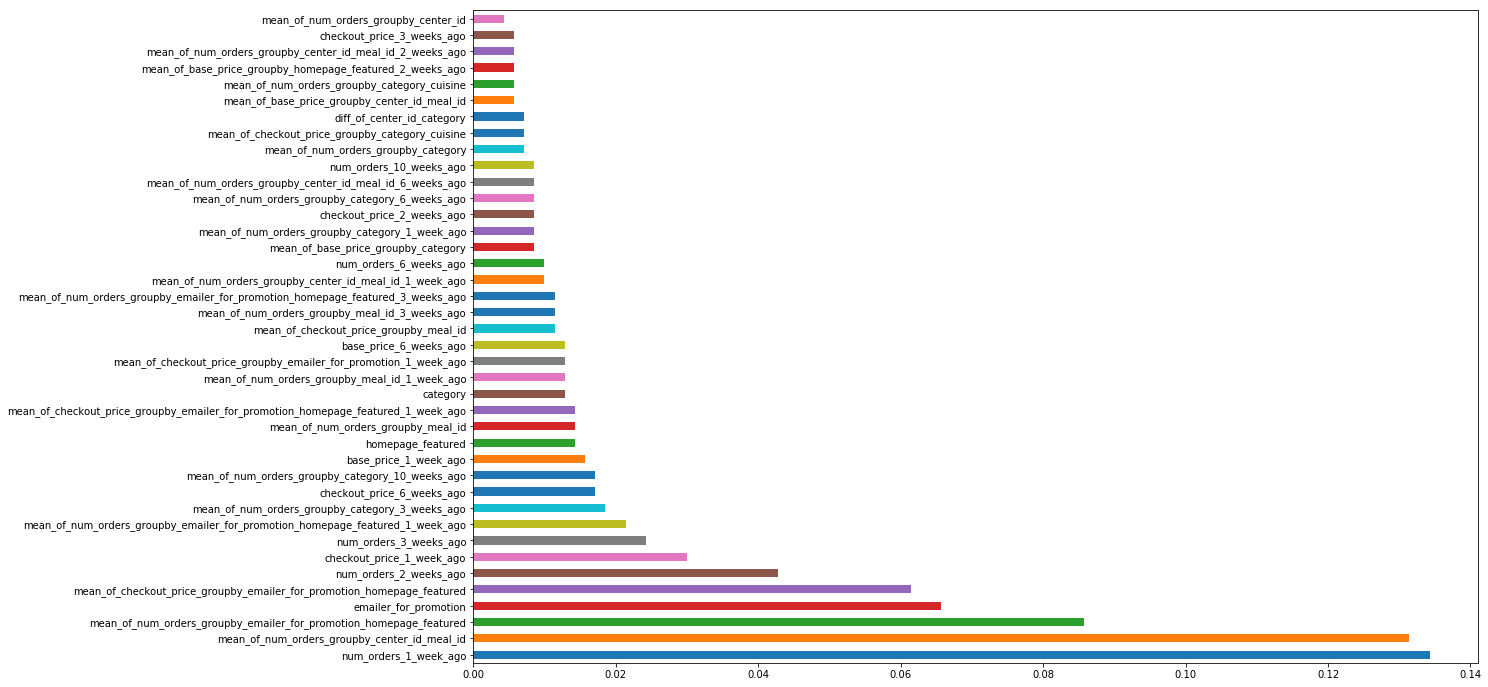

In [53]:
# plot the chart with top 40 important features
(pd.Series(model.feature_importances_, index=features)
   .nlargest(40)
   .plot(kind='barh', figsize=(18,12))) 

In [54]:
# Selected top 40 features for the final model
df = (pd.Series(model.feature_importances_, index=features).nlargest(40)).reset_index()
features = list(df['index'])
features

['num_orders_1_week_ago',
 'mean_of_num_orders_groupby_center_id_meal_id',
 'mean_of_num_orders_groupby_emailer_for_promotion_homepage_featured',
 'emailer_for_promotion',
 'mean_of_checkout_price_groupby_emailer_for_promotion_homepage_featured',
 'num_orders_2_weeks_ago',
 'checkout_price_1_week_ago',
 'num_orders_3_weeks_ago',
 'mean_of_num_orders_groupby_emailer_for_promotion_homepage_featured_1_week_ago',
 'mean_of_num_orders_groupby_category_3_weeks_ago',
 'checkout_price_6_weeks_ago',
 'mean_of_num_orders_groupby_category_10_weeks_ago',
 'base_price_1_week_ago',
 'homepage_featured',
 'mean_of_num_orders_groupby_meal_id',
 'mean_of_checkout_price_groupby_emailer_for_promotion_homepage_featured_1_week_ago',
 'category',
 'mean_of_num_orders_groupby_meal_id_1_week_ago',
 'mean_of_checkout_price_groupby_emailer_for_promotion_1_week_ago',
 'base_price_6_weeks_ago',
 'mean_of_checkout_price_groupby_meal_id',
 'mean_of_num_orders_groupby_meal_id_3_weeks_ago',
 'mean_of_num_orders_group

## Model Evaluation with the selected features

In [55]:
model.fit(X_train[features], Y_train)
Y_pred = model.predict(X_valid[features])

In [56]:
def eval_rmsle(actual, pred):
    rmse = 100 * np.sqrt(mean_squared_log_error(actual, pred))
    print('Root Mean Squared Log Error :', rmse)
    return rmse

In [57]:
print(Y_pred.min(), Y_pred.max())

-24.764637 2442.7964


In [58]:
Y_pred = np.clip(Y_pred, 0, 2500)

In [59]:
rmse = eval_rmsle(Y_valid, Y_pred)

Root Mean Squared Log Error : 57.02053178365265


## Plot the error terms

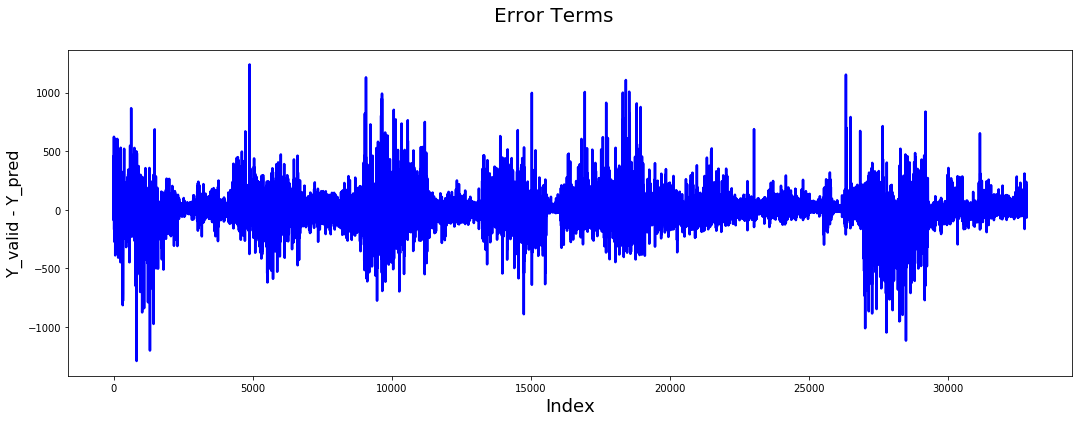

In [60]:
# Error terms
c = [i for i in range(len(Y_pred))]
fig = plt.figure(figsize=(18,6))
plt.plot(c, Y_valid - Y_pred, color="blue", linewidth=2.5, linestyle="-")
fig.suptitle('Error Terms', fontsize=20)              # Plot heading 
plt.xlabel('Index', fontsize=18)                      # X-label
plt.ylabel('Y_valid - Y_pred', fontsize=16)                # Y-label
plt.show()

## Predict with the test data

In [61]:
print(X[features].shape, Y.shape)
print(test[features].shape)

Y = np.clip(Y, 0, 2500)

(456285, 40) (456285,)
(32573, 40)


In [62]:
model.fit(X[features], Y)
Y_final_pred = model.predict(test[features])

In [63]:
print(Y_final_pred.min(), Y_final_pred.max())

-37.136353 2531.2205


## Prepare the submission file

In [64]:
test['num_orders'] = np.clip(Y_final_pred, 0, 2600)
test[['id', 'num_orders']].to_csv('genpact_xgb_submission.csv', index=False)

**With this initial submission, obtained the score of about 63.17.**

**Now let's go ahead and try with the hyperparameter tuning and stacking**

#### Selected final features

In [65]:
features

['num_orders_1_week_ago',
 'mean_of_num_orders_groupby_center_id_meal_id',
 'mean_of_num_orders_groupby_emailer_for_promotion_homepage_featured',
 'emailer_for_promotion',
 'mean_of_checkout_price_groupby_emailer_for_promotion_homepage_featured',
 'num_orders_2_weeks_ago',
 'checkout_price_1_week_ago',
 'num_orders_3_weeks_ago',
 'mean_of_num_orders_groupby_emailer_for_promotion_homepage_featured_1_week_ago',
 'mean_of_num_orders_groupby_category_3_weeks_ago',
 'checkout_price_6_weeks_ago',
 'mean_of_num_orders_groupby_category_10_weeks_ago',
 'base_price_1_week_ago',
 'homepage_featured',
 'mean_of_num_orders_groupby_meal_id',
 'mean_of_checkout_price_groupby_emailer_for_promotion_homepage_featured_1_week_ago',
 'category',
 'mean_of_num_orders_groupby_meal_id_1_week_ago',
 'mean_of_checkout_price_groupby_emailer_for_promotion_1_week_ago',
 'base_price_6_weeks_ago',
 'mean_of_checkout_price_groupby_meal_id',
 'mean_of_num_orders_groupby_meal_id_3_weeks_ago',
 'mean_of_num_orders_group

## Write the data to file for future use

In [66]:
pd.concat([pd.DataFrame(X, columns=X.columns), pd.DataFrame(Y, columns=['num_orders'])], axis=1).to_csv('train_data.csv', index=False)

In [67]:
test.to_csv('test_data.csv', index=False)

In [68]:
#del master_df
import gc
gc.collect()

71

#### Since the data size is huge, doing hyperparameter tuning randomly rather than using GridSearch

## XGBRegressor

### Hyperparameter tuning 1

In [69]:
model = XGBRegressor(max_depth=5)
model.fit(X_train[features], Y_train)
Y_pred = model.predict(X_valid[features])

In [70]:
print(Y_pred.min(), Y_pred.max())

6.1271734 2525.2524


In [71]:
Y_pred = np.clip(Y_pred, 0, 3000)

In [72]:
rmse = eval_rmsle(Y_valid, Y_pred)

Root Mean Squared Log Error : 52.64906495334743


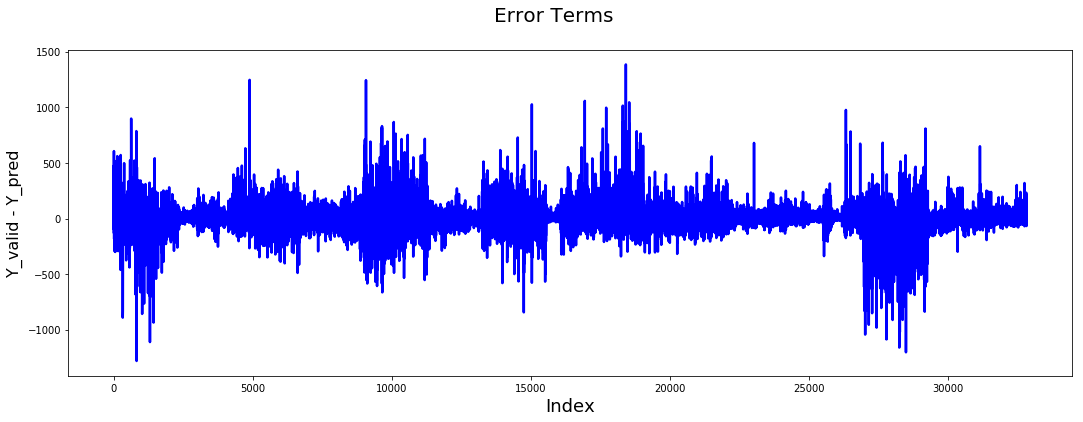

In [73]:
# Error terms
c = [i for i in range(len(Y_pred))]
fig = plt.figure(figsize=(18,6))
plt.plot(c, Y_valid - Y_pred, color="blue", linewidth=2.5, linestyle="-")
fig.suptitle('Error Terms', fontsize=20)              # Plot heading 
plt.xlabel('Index', fontsize=18)                      # X-label
plt.ylabel('Y_valid - Y_pred', fontsize=16)                # Y-label
plt.show()

### Hyperparameter tuning 2

In [74]:
model = XGBRegressor(max_depth=10)
model.fit(X_train[features], Y_train)
Y_pred = model.predict(X_valid[features])

In [75]:
print(Y_pred.min(), Y_pred.max())

-2.499721 2464.636


In [76]:
Y_pred = np.clip(Y_pred, 0, 3000)

In [77]:
rmse = eval_rmsle(Y_valid, Y_pred)

Root Mean Squared Log Error : 51.179260624689746


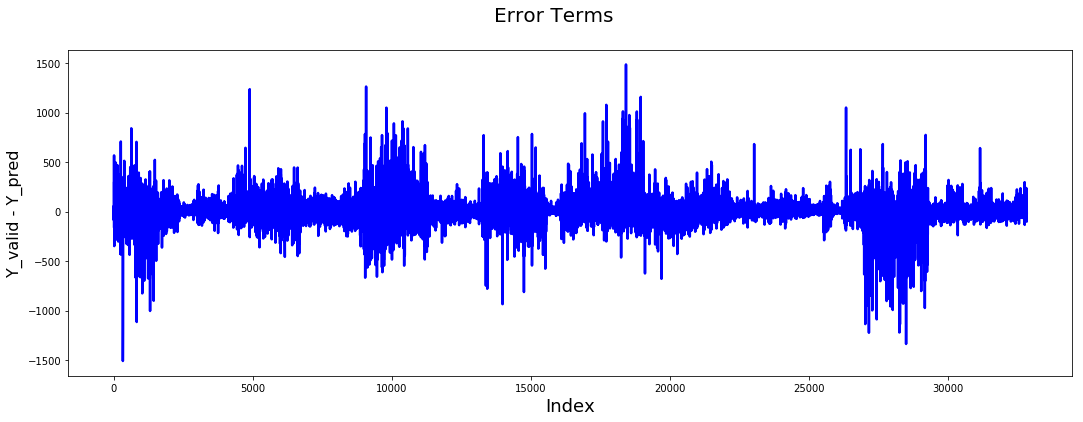

In [78]:
# Error terms
c = [i for i in range(len(Y_pred))]
fig = plt.figure(figsize=(18,6))
plt.plot(c, Y_valid - Y_pred, color="blue", linewidth=2.5, linestyle="-")
fig.suptitle('Error Terms', fontsize=20)              # Plot heading 
plt.xlabel('Index', fontsize=18)                      # X-label
plt.ylabel('Y_valid - Y_pred', fontsize=16)                # Y-label
plt.show()

### Hyperparameter tuning 3

In [79]:
model = XGBRegressor(max_depth=8)
model.fit(X_train[features], Y_train)
Y_pred = model.predict(X_valid[features])

In [80]:
print(Y_pred.min(), Y_pred.max())

12.93147 2529.8083


In [81]:
Y_pred = np.clip(Y_pred, 0, 3000)

In [82]:
rmse = eval_rmsle(Y_valid, Y_pred)

Root Mean Squared Log Error : 51.49874901746255


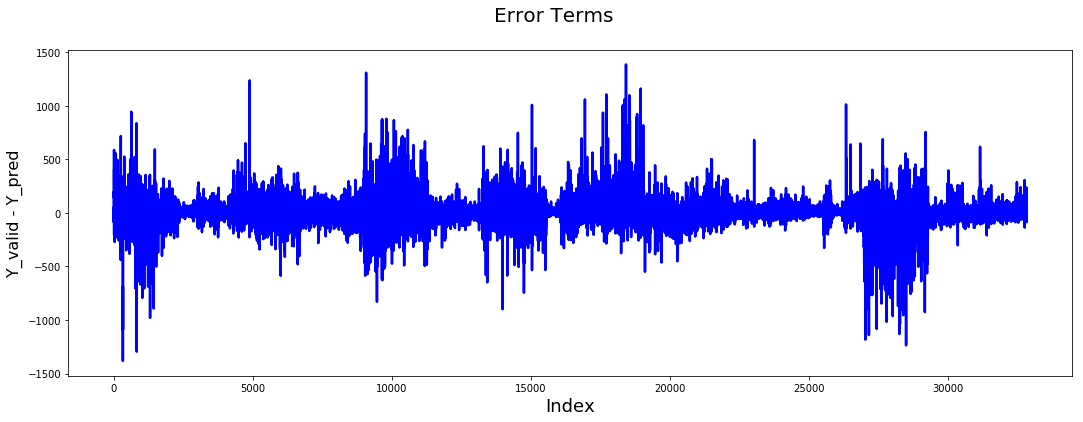

In [83]:
# Error terms
c = [i for i in range(len(Y_pred))]
fig = plt.figure(figsize=(18,6))
plt.plot(c, Y_valid - Y_pred, color="blue", linewidth=2.5, linestyle="-")
fig.suptitle('Error Terms', fontsize=20)              # Plot heading 
plt.xlabel('Index', fontsize=18)                      # X-label
plt.ylabel('Y_valid - Y_pred', fontsize=16)                # Y-label
plt.show()

## KNN Regressor

In [84]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X_train[features])

C:\Users\jsaikumar\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


MinMaxScaler(copy=True, feature_range=(0, 1))

In [85]:
from sklearn.neighbors import KNeighborsRegressor

model = KNeighborsRegressor(n_neighbors=2, n_jobs=-1, algorithm='kd_tree')
model.fit(scaler.transform(X_train[features]), Y_train)
Y_pred = model.predict(scaler.transform(X_valid[features]))

In [86]:
print(Y_pred.min(), Y_pred.max())

13.0 2500.0


In [87]:
Y_pred = np.clip(Y_pred, 0, 3000)

In [88]:
rmse = eval_rmsle(Y_valid, Y_pred)

Root Mean Squared Log Error : 62.41560503350677


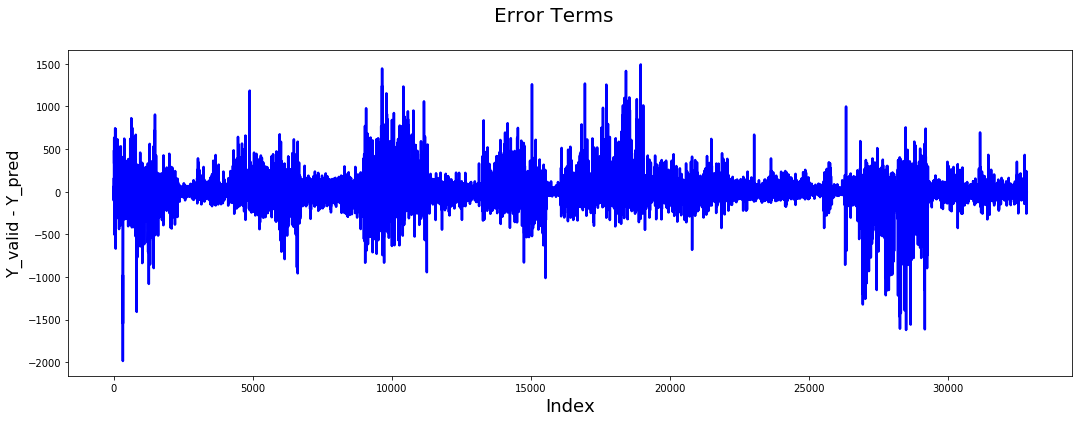

In [89]:
# Error terms
c = [i for i in range(len(Y_pred))]
fig = plt.figure(figsize=(18,6))
plt.plot(c, Y_valid - Y_pred, color="blue", linewidth=2.5, linestyle="-")
fig.suptitle('Error Terms', fontsize=20)              # Plot heading 
plt.xlabel('Index', fontsize=18)                      # X-label
plt.ylabel('Y_valid - Y_pred', fontsize=16)                # Y-label
plt.show()

### Hyperparameter Tuning 1

In [90]:
model = KNeighborsRegressor(n_neighbors=12, n_jobs=-1, algorithm='kd_tree')
model.fit(scaler.transform(X_train[features]), Y_train)
Y_pred = model.predict(scaler.transform(X_valid[features]))

In [91]:
print(Y_pred.min(), Y_pred.max())

13.666666666666666 2500.0


In [92]:
Y_pred = np.clip(Y_pred, 0, 3000)

In [93]:
rmse = eval_rmsle(Y_valid, Y_pred)

Root Mean Squared Log Error : 56.160093514559485


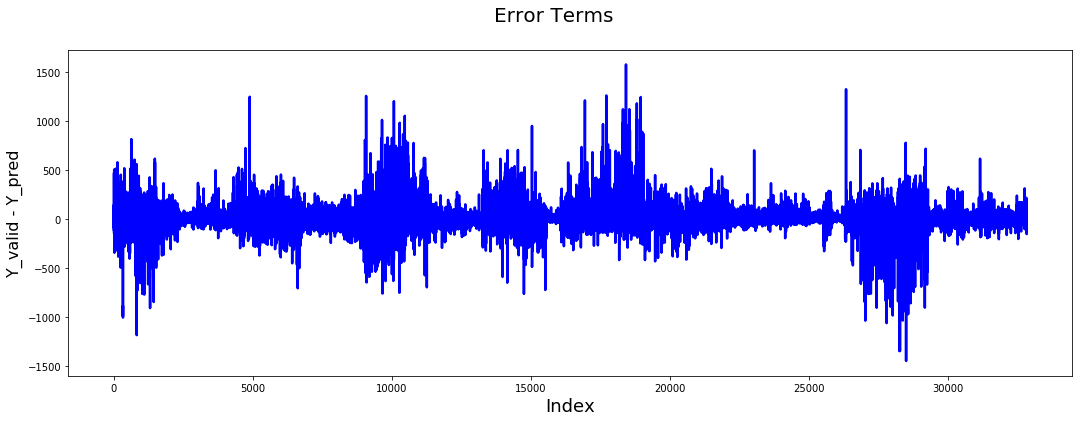

In [94]:
# Error terms
c = [i for i in range(len(Y_pred))]
fig = plt.figure(figsize=(18,6))
plt.plot(c, Y_valid - Y_pred, color="blue", linewidth=2.5, linestyle="-")
fig.suptitle('Error Terms', fontsize=20)              # Plot heading 
plt.xlabel('Index', fontsize=18)                      # X-label
plt.ylabel('Y_valid - Y_pred', fontsize=16)                # Y-label
plt.show()

In [95]:
pd.DataFrame({'actual':Y_valid, 'pred':Y_pred, 'diff':Y_valid-Y_pred})

,actual,pred,diff
135,134.0,157.583333,-23.583333
136,96.0,143.166667,-47.166667
137,81.0,133.000000,-52.000000
138,67.0,155.250000,-88.250000
139,204.0,157.500000,46.500000
140,107.0,170.083333,-63.083333
141,121.0,154.416667,-33.416667
142,176.0,157.750000,18.250000
143,162.0,145.166667,16.833333
144,121.0,152.000000,-31.000000


## Final Model Building with Stacking

In [96]:
print(X[features].shape, Y.shape)
print(test[features].shape)

Y = np.clip(Y, 0, 1500)

(456285, 40) (456285,)
(32573, 40)


### Model 1

In [97]:
model = XGBRegressor(max_depth=6)
model.fit(X[features], Y)
Y_train_pred_1 = model.predict(X[features])
Y_final_pred_1 = model.predict(test[features])

In [98]:
print(Y_final_pred_1.min(), Y_final_pred_1.max())

-64.220795 1710.5914


### Model 2

In [99]:
model = XGBRegressor(max_depth=8)
model.fit(X[features], Y)
Y_train_pred_2 = model.predict(X[features])
Y_final_pred_2 = model.predict(test[features])

In [100]:
print(Y_final_pred_2.min(), Y_final_pred_2.max())

-34.156776 1531.214


### Model 3

In [101]:
model = XGBRegressor(max_depth=10)
model.fit(X[features], Y)
Y_train_pred_3 = model.predict(X[features])
Y_final_pred_3 = model.predict(test[features])

In [102]:
print(Y_final_pred_3.min(), Y_final_pred_3.max())

-40.549507 1601.7281


### Model 4

In [103]:
scaler.fit(X[features])

C:\Users\jsaikumar\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


MinMaxScaler(copy=True, feature_range=(0, 1))

In [104]:
model = KNeighborsRegressor(n_neighbors=12, n_jobs=-1, algorithm='kd_tree')
model.fit(scaler.transform(X[features]), Y)
Y_train_pred_4 = model.predict(scaler.transform(X[features]))
Y_final_pred_4 = model.predict(scaler.transform(test[features]))

In [105]:
print(Y_final_pred_4.min(), Y_final_pred_4.max())

13.583333333333334 1500.0


### Model 5

In [106]:
model = KNeighborsRegressor(n_neighbors=16, n_jobs=-1, algorithm='kd_tree')
model.fit(scaler.transform(X[features]), Y)
Y_train_pred_5 = model.predict(scaler.transform(X[features]))
Y_final_pred_5 = model.predict(scaler.transform(test[features]))

In [107]:
print(Y_final_pred_5.min(), Y_final_pred_5.max())

14.625 1500.0


### Model 6

In [108]:
model = KNeighborsRegressor(n_neighbors=20, n_jobs=-1, algorithm='kd_tree')
model.fit(scaler.transform(X[features]), Y)
Y_train_pred_6 = model.predict(scaler.transform(X[features]))
Y_final_pred_6 = model.predict(scaler.transform(test[features]))

In [109]:
print(Y_final_pred_6.min(), Y_final_pred_6.max())

14.45 1500.0


## Final dataset preparation

In [110]:
X_train_final = pd.concat( 
                        [    
                            pd.DataFrame(X[features], columns=features), 
                            pd.DataFrame(Y_train_pred_1, columns=['xgb_max_depth_6']),
                            pd.DataFrame(Y_train_pred_2, columns=['xgb_max_depth_8']),
                            pd.DataFrame(Y_train_pred_3, columns=['xgb_max_depth_10']),
                            pd.DataFrame(Y_train_pred_4, columns=['knn_n_neighbors_12']),
                            pd.DataFrame(Y_train_pred_5, columns=['knn_n_neighbors_16']),
                            pd.DataFrame(Y_train_pred_6, columns=['knn_n_neighbors_20']),
                        ]
                        , axis=1
                    )

In [111]:
X_test_final = pd.concat( 
                        [    
                            pd.DataFrame(test[features], columns=features), 
                            pd.DataFrame(Y_final_pred_1, columns=['xgb_max_depth_6']),
                            pd.DataFrame(Y_final_pred_2, columns=['xgb_max_depth_8']),
                            pd.DataFrame(Y_final_pred_3, columns=['xgb_max_depth_10']),
                            pd.DataFrame(Y_final_pred_4, columns=['knn_n_neighbors_12']),
                            pd.DataFrame(Y_final_pred_5, columns=['knn_n_neighbors_16']),
                            pd.DataFrame(Y_final_pred_6, columns=['knn_n_neighbors_20']),
                        ]
                        , axis=1
                    )

## Stacking above model results with Ridge Regressor 

In [112]:
from sklearn.linear_model import Ridge
model = Ridge(alpha=1, copy_X=True, normalize=True, max_iter=1000)
model.fit(scaler.fit_transform(X_train_final), Y)

C:\Users\jsaikumar\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int32, float32, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Ridge(alpha=1, copy_X=True, fit_intercept=True, max_iter=1000, normalize=True,
   random_state=None, solver='auto', tol=0.001)

In [113]:
Y_test_final_pred = model.predict(scaler.transform(X_test_final))

In [114]:
print(Y_test_final_pred.min(), Y_test_final_pred.max())

3.886868871625385 1337.9882207253


In [115]:
test['num_orders'] = np.clip(Y_test_final_pred, 0, 2000)
test['num_orders'] = np.round(test['num_orders'], 1)
test[['id', 'num_orders']].to_csv('genpact_stack_submission.csv', index=False)

#### This final submission obtained the score of 62.27